# Confidence Intervals (C.10)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import binom
from scipy import optimize

In our article, for the sake of conciseness, we do not give the confidence interval for each number in the body of the article and in the tables.

The following function computes the exact confidence interval for a repeated Bernouilli, with *k* successes out of *n* independent samples. The parameter *confidence* specifies the desired level of confidence, e.g. 95%. This function is adapted from https://github.com/KazKobara/ebcic.

In [2]:
def exact_confidence_interval(n, k, confidence):
    """Return exact Binomial confidence interval for the parameter.

    Returns:
            lower_p (float): lower bound of Binomial confidence interval.
            upper_p (float): upper bound of Binomial confidence interval.
    """
    alpha = 1 - confidence
    r = alpha / 2
    if k > n / 2:
        # Cumulative error becomes large for k >> n/2,
        # so make k < n/2.
        k = n - k
        reverse_mode = True
    else:
        reverse_mode = False

    def upper(p):
        """
        Upper bound is the p making the following 0.
        """
        return binom.cdf(k, n, p) - r

    def lower(p):
        """
        Lower bound for k>0 is the p making the following 0.
        """
        return binom.cdf(n - k, n, 1 - p) - r

    if k == 0:
        lower_p = 0.0
        upper_p = 1 - (alpha)**(1 / n)
    else:
        # 0 < k <= n/2
        u_init = k / n
        l_init = k / n
        if k == 1:
            l_init = 0
        elif k == 2:
            l_init = k / (2 * n)
        lower_p = optimize.fsolve(lower, l_init)[0]
        if n == 2 and k == 1:
            # Exception of k/n = 1/2 and n is too small.
            upper_p = 1 - lower_p
        else:
            upper_p = optimize.fsolve(upper, u_init)[0]

    if reverse_mode:
        lower_p, upper_p = 1 - upper_p, 1 - lower_p

    return lower_p, upper_p

For 10,000 samples, we compute the 95% confidence interval for each possible value of the number of successes *k*:

In [3]:
N_SAMPLES = 10000
ks = np.array(range(N_SAMPLES + 1))
lowers = []
uppers = []
averages = []
for k in ks:
    lower, upper = exact_confidence_interval(n=N_SAMPLES, k=k, confidence=0.95)
    lowers.append(lower)
    uppers.append(upper)
    averages.append(k / N_SAMPLES)

We plot the upper and lower margins of error as a function of the empirical mean:

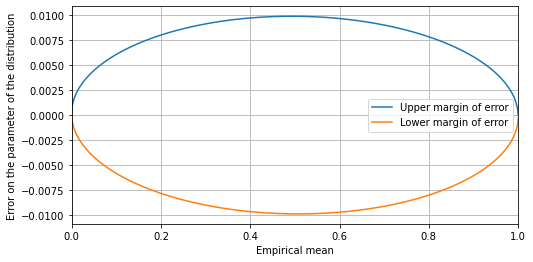

In [4]:
upper_margins = np.array(uppers) - np.array(averages)
lower_margins = np.array(lowers) - np.array(averages)
plt.subplots(figsize=(8, 4))
plt.plot(averages, upper_margins, label='Upper margin of error')
plt.plot(averages, lower_margins, label='Lower margin of error')
plt.xlabel('Empirical mean')
plt.ylabel('Error on the parameter of the distribution')
plt.xlim(0, 1)
plt.grid(True)
plt.legend()

Some examples:

In [5]:
ks_examples = (
    list(range(10)) 
    + list(range(10, 100, 10)) 
    + list(range(100, 500, 100))
    + list(range(1000, 9000, 1000))
    + list(range(9000, 9900, 100))
    + list(range(9900, 9990, 10))
    + list(range(9990, 10001, 1))
)
df = pd.DataFrame()
df.index.name = 'k'
for k in ks_examples:
    df.loc[k, 'Lower bound'] = "{:.4%}".format(lowers[k])
    df.loc[k, 'Empirical mean'] = "{:.4%}".format(averages[k])
    df.loc[k, 'Upper bound'] = "{:.4%}".format(uppers[k])
    df.loc[k, 'Width of the confidence interval'] = "{:.4%}".format(uppers[k] - lowers[k])
df

Lower bound Empirical mean Upper bound Width of the confidence interval
k                                                                            
0         0.0000%        0.0000%     0.0300%                          0.0300%
1         0.0003%        0.0100%     0.0557%                          0.0555%
2         0.0024%        0.0200%     0.0722%                          0.0698%
3         0.0062%        0.0300%     0.0876%                          0.0815%
4         0.0109%        0.0400%     0.1024%                          0.0915%
5         0.0162%        0.0500%     0.1166%                          0.1004%
6         0.0220%        0.0600%     0.1305%                          0.1085%
7         0.0281%        0.0700%     0.1442%                          0.1160%
8         0.0345%        0.0800%     0.1576%                          0.1230%
9         0.0412%        0.0900%     0.1708%                          0.1296%
10        0.0480%        0.1000%     0.1838%                          0.1359%
20        0.1222%        0.2000%     0.3087%                          0.1865%
30        0.2025%        0.3000%     0.4280%                          0.2255%
40        0.2859%        0.4000%     0.5443%                          0.2584%
50        0.3713%        0.5000%     0.6587%                          0.2873%
60        0.4582%        0.6000%     0.7717%                          0.3135%
70        0.5461%        0.7000%     0.8836%                          0.3375%
80        0.6348%        0.8000%     0.9947%                          0.3598%
90        0.7243%        0.9000%     1.1051%                          0.3808%
100       0.8144%        1.0000%     1.2150%                          0.4006%
200       1.7347%        2.0000%     2.2938%                          0.5591%
300       2.6744%        3.0000%     3.3533%                          0.6789%
400       3.6244%        4.0000%     4.4027%                          0.7783%
1000      9.4187%       10.0000%    10.6047%                          1.1860%
2000     19.2198%       20.0000%    20.7977%                          1.5778%
3000     29.1028%       30.0000%    30.9089%                          1.8061%
4000     39.0378%       40.0000%    40.9680%                          1.9301%
5000     49.0151%       50.0000%    50.9849%                          1.9697%
6000     59.0320%       60.0000%    60.9622%                          1.9301%
7000     69.0911%       70.0000%    70.8972%                          1.8061%
8000     79.2023%       80.0000%    80.7802%                          1.5778%
9000     89.3953%       90.0000%    90.5813%                          1.1860%
9100     90.4221%       91.0000%    91.5539%                          1.1318%
9200     91.4510%       92.0000%    92.5244%                          1.0735%
9300     92.4823%       93.0000%    93.4925%                          1.0102%
9400     93.5166%       94.0000%    94.4576%                          0.9410%
9500     94.5545%       95.0000%    95.4190%                          0.8645%
9600     95.5973%       96.0000%    96.3756%                          0.7783%
9700     96.6467%       97.0000%    97.3256%                          0.6789%
9800     97.7062%       98.0000%    98.2653%                          0.5591%
9900     98.7850%       99.0000%    99.1856%                          0.4006%
9910     98.8949%       99.1000%    99.2757%                          0.3808%
9920     99.0053%       99.2000%    99.3652%                          0.3598%
9930     99.1164%       99.3000%    99.4539%                          0.3375%
9940     99.2283%       99.4000%    99.5418%                          0.3135%
9950     99.3413%       99.5000%    99.6287%                          0.2873%
9960     99.4557%       99.6000%    99.7141%                          0.2584%
9970     99.5720%       99.7000%    99.7975%                          0.2255%
9980     99.6913%       99.8000%    99.8778%                          0.1865%
9990     99.8162%       99.9